### import the dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchdiffeq import odeint

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

DATA_PATH = os.path.join("..", "Dataset", "raw_RRI_segments.csv")
OUT_MODEL = os.path.join("..", "Two_Class_Models", "saved_models", "raw_hybrid_two_class_best.pth")

### Load Raw dataset and preprocess

In [2]:
df = pd.read_csv(DATA_PATH)

# Merge SR (0) + Pre-AF (1) → 0 (non-AF), keep AF (2) → 1 (AF)
mask_binary = df["label"].isin([0, 1, 2])
df = df[mask_binary].copy()

# Remap labels
df["label"] = df["label"].map({
    0: 0,  # SR → non-AF
    1: 0,  # Pre-AF → non-AF
    2: 1   # AF → AF
})

# Pick raw RRI columns (prefix 'r_')
feature_cols = [c for c in df.columns if c.startswith("r_")]
meta_cols = ["patient_id", "record_id", "label", "label_str", "orig_len"]

assert len(feature_cols) > 0, "No r_ columns found in CSV"

# Extract feature matrix and labels
X = df[feature_cols].values.astype(np.float32)
y = df["label"].values.astype(int)

# Drop rows with NaN or Inf
mask_good = np.isfinite(X).all(axis=1)
X = X[mask_good]
y = y[mask_good]

print("Loaded raw samples:", X.shape)
print("Class counts:", np.bincount(y))
print("Unique labels:", np.unique(y))


Loaded raw samples: (14357, 50)
Class counts: [9557 4800]
Unique labels: [0 1]


### Train / val / test split, scaling and SMOTE (apply SMOTE only to training set)

In [3]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=RANDOM_SEED
)

print("Splits -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# Standardize using training stats
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# SMOTE on training only
smote = SMOTE(random_state=RANDOM_SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE train distribution:", np.bincount(y_train_res))

Splits -> train: (9188, 50) val: (2297, 50) test: (2872, 50)


c:\Users\Michelle\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


After SMOTE train distribution: [6116 6116]


### Compute class weights

In [4]:
# compute class weights from resampled training set (used as alpha for focal loss)
cw = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_res), y=y_train_res)
class_weights_tensor = torch.tensor(cw, dtype=torch.float32)
print("Class weights:", cw)

Class weights: [1. 1.]


### Compute focal loss

In [5]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean()

### Define model class

In [6]:
# --- Model definitions (Hybrid NODE + Attention) ---
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 64),
            nn.Tanh(),
            nn.Linear(64, dim)
        )
    def forward(self, t, x):
        return self.net(x)

class SelfAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.scale = dim ** 0.5
    def forward(self, x):
        # x: [batch, dim] -> [batch, 1, dim]
        x1 = x.unsqueeze(1)
        Q = self.query(x1)
        K = self.key(x1)
        V = self.value(x1)
        scores = torch.softmax(torch.bmm(Q, K.transpose(1,2)) / self.scale, dim=-1)
        out = torch.bmm(scores, V)  # [batch,1,dim]
        return out.squeeze(1)

class HybridNODEAttentionModel(nn.Module):
    def __init__(self, dim, num_classes):
        super().__init__()
        self.odefunc = ODEFunc(dim)
        self.attn = SelfAttention(dim)
        self.classifier = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        # x: [batch, dim]
        t = torch.tensor([0.0, 1.0], dtype=x.dtype, device=x.device)
        ode_out = odeint(self.odefunc, x, t)[-1]
        attn_out = self.attn(ode_out)
        return self.classifier(attn_out)


### Prepare DataLoaders

In [7]:
BATCH_SIZE = 32
train_ds = TensorDataset(torch.from_numpy(X_train_res.astype(np.float32)), torch.from_numpy(y_train_res.astype(np.int64)))
val_ds = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val.astype(np.int64)))
test_ds = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.int64)))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)

### Train model (hyperparameter tuning)

In [9]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import torch.nn.functional as F
from sklearn.metrics import f1_score
import itertools
import numpy as np
import torch

def train_with_kfold_tuning(model_class, input_dim, num_classes,
                            full_dataset, class_weights_tensor,
                            param_grid,
                            save_path,
                            epochs=8, patience=2,
                            k_folds=5, device='cuda'):
    class_weights_tensor = class_weights_tensor.to(device)
    best_global_f1 = 0.0
    best_params = None
    best_state = None

    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    combos = list(itertools.product(*param_grid.values()))
    print(f"Total combinations: {len(combos)}  |  Using {k_folds}-fold cross-validation")

    for combo in combos:
        params = dict(zip(param_grid.keys(), combo))
        print(f"\nTesting hyperparameters: {params}")
        fold_f1s = []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(full_dataset)))):
            train_subset = Subset(full_dataset, train_idx)
            val_subset = Subset(full_dataset, val_idx)

            train_loader = DataLoader(train_subset, batch_size=params["batch_size"], shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=params["batch_size"], shuffle=False)

            model = model_class(dim=input_dim, num_classes=num_classes).to(device)
            optimizer = (
                torch.optim.Adam(model.parameters(), lr=params["lr"])
                if params["optimizer"] == "adam"
                else torch.optim.SGD(model.parameters(), lr=params["lr"], momentum=0.9)
            )
            criterion = FocalLoss(alpha=class_weights_tensor, gamma=params.get("gamma", 2.0))

            local_best = 0.0
            no_improve = 0

            for epoch in range(epochs):
                model.train()
                total_loss = 0
                for xb, yb in train_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    out = model(xb)
                    loss = criterion(out, yb)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item() * xb.size(0)

                # Validation
                model.eval()
                preds, trues = [], []
                with torch.no_grad():
                    for xb, yb in val_loader:
                        xb, yb = xb.to(device), yb.to(device)
                        out = model(xb)
                        preds.extend(torch.argmax(out, dim=1).cpu().numpy())
                        trues.extend(yb.cpu().numpy())

                val_f1 = f1_score(trues, preds, average="weighted")
                if val_f1 > local_best:
                    local_best = val_f1
                    no_improve = 0
                else:
                    no_improve += 1
                    if no_improve >= patience:
                        break

            fold_f1s.append(local_best)
            print(f"  Fold {fold+1}/{k_folds} F1: {local_best:.4f}")

        mean_f1 = np.mean(fold_f1s)
        print(f"Mean F1 for params {params}: {mean_f1:.4f}")

        if mean_f1 > best_global_f1:
            best_global_f1 = mean_f1
            best_params = params
            best_state = model.state_dict().copy()
            torch.save(best_state, save_path)
            print("  ✅ New best model saved.")

    print(f"\nBest overall F1: {best_global_f1:.4f} with params {best_params}")
    return best_params, best_global_f1, best_state



In [8]:
train_dataset = TensorDataset(torch.from_numpy(X_train_res.astype(np.float32)), torch.from_numpy(y_train_res.astype(np.int64)))
val_dataset = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val.astype(np.int64)))
test_dataset = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.int64)))

input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)

In [11]:
full_dataset = TensorDataset(
    torch.from_numpy(X_train_res.astype(np.float32)),
    torch.from_numpy(y_train_res.astype(np.int64))
)

param_grid = {
    "lr": [1e-3, 5e-4],
    "batch_size": [16, 32],
    "optimizer": ["adam", "sgd"]
}

best_params, best_f1, best_state = train_with_kfold_tuning(
    HybridNODEAttentionModel, input_dim, num_classes,
    full_dataset, class_weights_tensor,
    param_grid, save_path=OUT_MODEL,
    epochs=8, patience=2, k_folds=5, device=device
)


Total combinations: 8  |  Using 5-fold cross-validation

Testing hyperparameters: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'adam'}
  Fold 1/5 F1: 0.8737
  Fold 2/5 F1: 0.8765
  Fold 3/5 F1: 0.8794
  Fold 4/5 F1: 0.8789
  Fold 5/5 F1: 0.8720
Mean F1 for params {'lr': 0.001, 'batch_size': 16, 'optimizer': 'adam'}: 0.8761
  ✅ New best model saved.

Testing hyperparameters: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'sgd'}
  Fold 1/5 F1: 0.8561
  Fold 2/5 F1: 0.8306
  Fold 3/5 F1: 0.8552
  Fold 4/5 F1: 0.8367
  Fold 5/5 F1: 0.8433
Mean F1 for params {'lr': 0.001, 'batch_size': 16, 'optimizer': 'sgd'}: 0.8444

Testing hyperparameters: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'adam'}
  Fold 1/5 F1: 0.8847
  Fold 2/5 F1: 0.8724
  Fold 3/5 F1: 0.8749
  Fold 4/5 F1: 0.8694
  Fold 5/5 F1: 0.8658
Mean F1 for params {'lr': 0.001, 'batch_size': 32, 'optimizer': 'adam'}: 0.8734

Testing hyperparameters: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'sgd'}
  Fold 1/5 F1: 0.8537
  Fold 2/5 F1

### Final evaluation on test set

In [12]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import numpy as np
import torch

# --- Load best model for final evaluation ---
if best_state is not None:
    best_model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes)
    best_model.load_state_dict(best_state)
    best_model = best_model.to(device)
    print("✅ Loaded best model from training.")
else:
    best_model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes).to(device)
    print("⚠️ No best_state found, using new untrained model.")

# --- Create test loader if missing ---
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Evaluate on test set ---
best_model.eval()
test_preds, test_trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = best_model(xb)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_trues.extend(yb.cpu().numpy())

test_preds = np.array(test_preds)
test_trues = np.array(test_trues)

# --- Metrics ---
acc = accuracy_score(test_trues, test_preds)
f1 = f1_score(test_trues, test_preds, average="weighted")
precision = precision_score(test_trues, test_preds, average="weighted", zero_division=0)
recall = recall_score(test_trues, test_preds, average="weighted", zero_division=0)
cm = confusion_matrix(test_trues, test_preds)

print("\n📊 Final Test Results:")
print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

print("\nDetailed classification report:")
print(classification_report(test_trues, test_preds, digits=4))

print("\nConfusion Matrix:")
print(cm)


✅ Loaded best model from training.

📊 Final Test Results:
Accuracy:  0.8774
F1 Score:  0.8785
Precision: 0.8809
Recall:    0.8774

Detailed classification report:
              precision    recall  f1-score   support

           0     0.9248    0.8881    0.9061      1912
           1     0.7934    0.8562    0.8236       960

    accuracy                         0.8774      2872
   macro avg     0.8591    0.8722    0.8649      2872
weighted avg     0.8809    0.8774    0.8785      2872


Confusion Matrix:
[[1698  214]
 [ 138  822]]


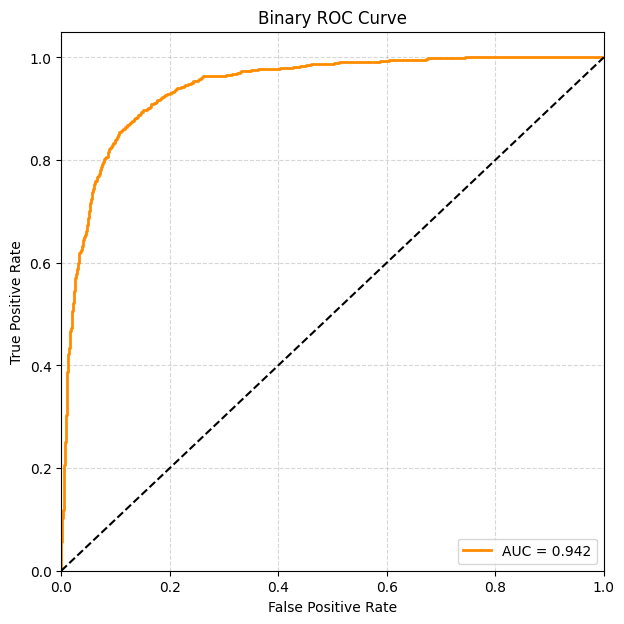


AUC = 0.9423


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
input_dim = X_test.shape[1]
num_classes = 2

model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes)
model.load_state_dict(torch.load(OUT_MODEL, map_location='cpu'))
model = model.to(device)
model.eval()

probs_all = []
y_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1).cpu().numpy()
        probs_all.append(probs)
        y_true.extend(yb.numpy())

probs_all = np.vstack(probs_all)
y_true = np.array(y_true)
y_score = probs_all[:, 1]

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, lw=2, color='darkorange', label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Binary ROC Curve")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="lower right")
plt.show()

print(f"\nAUC = {roc_auc:.4f}")

### Find threshold

In [11]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    balanced_accuracy_score, confusion_matrix, classification_report
)
from torch.utils.data import DataLoader, TensorDataset

test_dataset = TensorDataset(
    torch.from_numpy(X_test.astype(np.float32)),
    torch.from_numpy(y_test.astype(np.int64))
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

prob_af = []
true_labels = []

model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1).cpu().numpy()
        prob_af.extend(probs[:, 1])
        true_labels.extend(yb.numpy())

prob_af = np.array(prob_af)
true_labels = np.array(true_labels)

print("Probability range:", prob_af.min(), "-", prob_af.max())
print("Label distribution (0=SR, 1=AF):", np.bincount(true_labels))


Probability range: 6.5969056e-05 - 0.9035179
Label distribution (0=SR, 1=AF): [1912  960]


In [12]:
coarse = np.arange(0.0, 1.01, 0.05)
fine = np.arange(0.50, 0.601, 0.01)
candidates = np.unique(np.concatenate([coarse, fine]))

f1s, accs, precs, recs = [], [], [], []

for t in candidates:
    preds = (prob_af >= t).astype(int)
    f1s.append(f1_score(true_labels, preds))
    accs.append(accuracy_score(true_labels, preds))
    precs.append(precision_score(true_labels, preds, zero_division=0))
    recs.append(recall_score(true_labels, preds))

scores = [(f1s[i] + accs[i]) / 2 for i in range(len(candidates))]
best_idx = np.argmax(scores)
best_t = candidates[best_idx]

print(f"\nBest threshold = {best_t:.3f}")
print(f"F1={f1s[best_idx]:.4f}, Acc={accs[best_idx]:.4f}, "
      f"Prec={precs[best_idx]:.4f}, Rec={recs[best_idx]:.4f}")



Best threshold = 0.510
F1=0.8241, Acc=0.8788, Prec=0.8006, Rec=0.8490


In [13]:
# --- Show all thresholds with F1 and Accuracy ---
print("\n========== Threshold Summary ==========")
print(f"{'Threshold':<10} {'F1':<10} {'Accuracy':<10}")
print("-" * 35)

for i, t in enumerate(candidates):
    print(f"{t:<10.2f} {f1s[i]:<10.4f} {accs[i]:<10.4f}")




========== Threshold Summary ==========
Threshold  F1         Accuracy  
-----------------------------------
0.00       0.5010     0.3343    
0.05       0.5329     0.4140    
0.10       0.5725     0.5007    
0.15       0.5961     0.5481    
0.20       0.6189     0.5905    
0.25       0.6593     0.6584    
0.30       0.7334     0.7636    
0.35       0.7802     0.8203    
0.40       0.8016     0.8464    
0.45       0.8120     0.8607    
0.50       0.8236     0.8774    
0.51       0.8241     0.8788    
0.52       0.8233     0.8795    
0.53       0.8219     0.8799    
0.54       0.8212     0.8802    
0.55       0.8154     0.8781    
0.56       0.8175     0.8806    
0.57       0.8136     0.8795    
0.58       0.8079     0.8774    
0.59       0.8053     0.8774    
0.60       0.7971     0.8740    
0.65       0.7540     0.8562    
0.70       0.7038     0.8391    
0.75       0.5896     0.7998    
0.80       0.4739     0.7650    
0.85       0.2590     0.7131    
0.90       0.0062     0.6668    

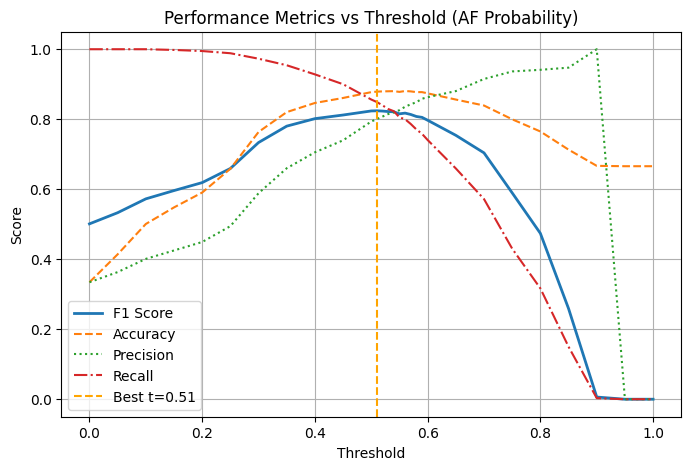

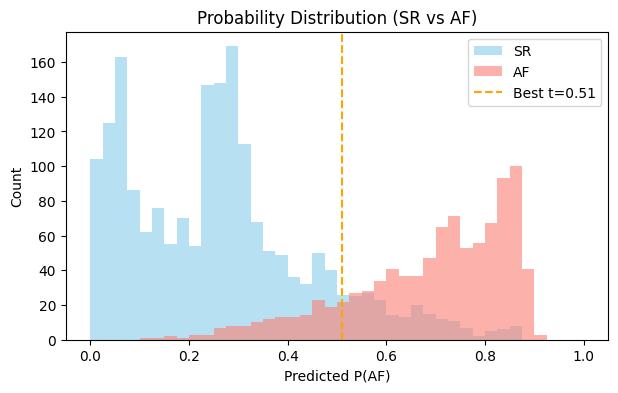

In [14]:
plt.figure(figsize=(8,5))
plt.plot(candidates, f1s, label="F1 Score", linewidth=2)
plt.plot(candidates, accs, label="Accuracy", linestyle="--")
plt.plot(candidates, precs, label="Precision", linestyle=":")
plt.plot(candidates, recs, label="Recall", linestyle="-.")
plt.axvline(best_t, color="orange", linestyle="--", label=f"Best t={best_t:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Performance Metrics vs Threshold (AF Probability)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.hist(prob_af[true_labels==0], bins=40, range=(0,1), alpha=0.6, label="SR", color="skyblue")
plt.hist(prob_af[true_labels==1], bins=40, range=(0,1), alpha=0.6, label="AF", color="salmon")
plt.axvline(best_t, color="orange", linestyle="--", label=f"Best t={best_t:.2f}")
plt.xlabel("Predicted P(AF)")
plt.ylabel("Count")
plt.title("Probability Distribution (SR vs AF)")
plt.legend()
plt.show()
